In [1]:
!pip install nibabel
!pip install medicaltorch
!pip install visdom

In [2]:
#@title Default title text
import numpy as np
import numbers
import torchvision.transforms.functional as F
from torchvision import transforms
from PIL import Image
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import torchvision.transforms.functional

class MTTransform(object):

    def __call__(self, sample):
        raise NotImplementedError("You need to implement the transform() method.")

    def undo_transform(self, sample):
        raise NotImplementedError("You need to implement the undo_transform() method.")


class UndoCompose(object):
    def __init__(self, compose):
        self.transforms = compose.transforms

    def __call__(self):
        for t in self.transforms:
            img = t.undo_transform(img)
        return img


class UndoTransform(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        return self.transform.undo_transform(sample)


class ToTensor(MTTransform):
    """Convert a PIL image or numpy array to a PyTorch tensor."""

    def __init__(self, labeled=True):
        self.labeled = labeled

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        if isinstance(input_data, list):
            ret_input = [F.to_tensor(item)
                         for item in input_data]
        else:
            ret_input = F.to_tensor(input_data)

        rdict['input'] = ret_input

        if self.labeled:
            gt_data = sample['gt']
            if gt_data is not None:
                if isinstance(gt_data, list):
                    ret_gt = [F.to_tensor(item)
                              for item in gt_data]
                else:
                    ret_gt = F.to_tensor(gt_data)

                rdict['gt'] = ret_gt

        sample.update(rdict)
        return sample


class ToPIL(MTTransform):
    def __init__(self, labeled=True):
        self.labeled = labeled

    def sample_transform(self, sample_data):
        # Numpy array
        if not isinstance(sample_data, np.ndarray):
            input_data_npy = sample_data.numpy()
        else:
            input_data_npy = sample_data

        input_data_npy = np.transpose(input_data_npy, (1, 2, 0))
        input_data_npy = np.squeeze(input_data_npy, axis=2)
        input_data = Image.fromarray(input_data_npy, mode='F')
        return input_data

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        if isinstance(input_data, list):
            ret_input = [self.sample_transform(item)
                         for item in input_data]
        else:
            ret_input = self.sample_transform(input_data)

        rdict['input'] = ret_input

        if self.labeled:
            gt_data = sample['gt']

            if isinstance(gt_data, list):
                ret_gt = [self.sample_transform(item)
                          for item in gt_data]
            else:
                ret_gt = self.sample_transform(gt_data)

            rdict['gt'] = ret_gt

        sample.update(rdict)
        return sample


class res(MTTransform):
    """Make a center crop of a specified size.

    :param segmentation: if it is a segmentation task.
                         When this is True (default), the crop
                         will also be applied to the ground truth.
    """
    def __init__(self, size, labeled=True):
        self.size = size
        self.labeled = labeled

    @staticmethod
    def propagate_params(sample, params):
        input_metadata = sample['input_metadata']
        input_metadata["__centercrop"] = params
        return input_metadata

    @staticmethod
    def get_params(sample):
        input_metadata = sample['input_metadata']
        return input_metadata["__centercrop"]

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        w, h = input_data.size
        th, tw = self.size
        fh = int(round((h - th) / 2.))
        fw = int(round((w - tw) / 2.))

        params = (fh, fw, w, h)
        self.propagate_params(sample, params)

        input_data = torchvision.transforms.functional.resize(input_data, self.size)
        rdict['input'] = input_data

        if self.labeled:
            gt_data = sample['gt']
            gt_metadata = sample['gt_metadata']
            gt_data = torchvision.transforms.functional.resize(gt_data, self.size)
            gt_metadata["__centercrop"] = (fh, fw, w, h)
            rdict['gt'] = gt_data


        sample.update(rdict)
        return sample

    def undo_transform(self, sample):
        rdict = {}
        input_data = sample['input']
        fh, fw, w, h = self.get_params(sample)
        th, tw = self.size

        pad_left = fw
        pad_right = w - pad_left - tw
        pad_top = fh
        pad_bottom = h - pad_top - th

        padding = (pad_left, pad_top, pad_right, pad_bottom)
        input_data = F.pad(input_data, padding)
        rdict['input'] = input_data

        sample.update(rdict)
        return sample







In [3]:
# for custom dataset class
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import glob
import nibabel as nib
import os
from medicaltorch import datasets as mt_datasets
from medicaltorch import transforms as mt_transforms
import matplotlib.pyplot as plt
from google.colab import drive
import torch.nn as nn
import math
import visdom

In [4]:
drive.mount('/gdrive')
ROOT_DIR = "/gdrive/My Drive/MM-WHS 2017 Dataset/"
# ROOT_DIR = 'drive/MyDrive/MM-WHS 2017 Dataset/'
mri_input_filename = os.path.join(ROOT_DIR,'ct_train',
                                          'ct_train_1001_image.nii.gz')
mri_gt_filename = os.path.join(ROOT_DIR,'ct_train',
                                          'ct_train_1001_label.nii.gz')

pair = mt_datasets.SegmentationPair2D(mri_input_filename, mri_gt_filename)
slice_pair = pair.get_pair_slice(159)
input_slice = slice_pair["input"]
gt_slice = slice_pair["gt"]

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


(512, 512)


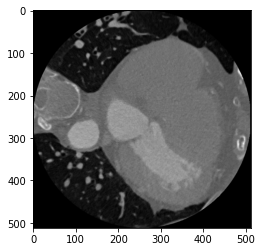

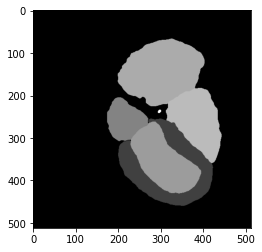

(512, 512, 363)

In [5]:
print(input_slice.shape)
img = input_slice
plt.imshow(img,cmap = 'gray')
plt.show()
img = gt_slice
plt.imshow(img,cmap = 'gray')
plt.show()

img_data,seg_data = pair.get_pair_data()
img_data.shape
seg_data.shape

In [6]:
# img_list = os.listdir(os.path.join(ROOT_DIR,'mr_train'))
# label_list = os.listdir(os.path.join(ROOT_DIR,'labelsTr'))
img_list = sorted(glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*image.nii.gz"))
label_list = sorted(glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*label.nii.gz"))

In [7]:
# filename_pairs = [(glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*image.nii.gz",x),glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*label.nii.gz",y)) for x,y in zip(img_list,label_list)]
filename_pairs = [(os.path.join(ROOT_DIR,'mr_train',x),os.path.join(ROOT_DIR,'mr_train',y)) for x,y in zip(img_list,label_list)]
# filename_pairs

In [8]:
# img_list = os.listdir(os.path.join(ROOT_DIR,'mr_train'))
# label_list = os.listdir(os.path.join(ROOT_DIR,'labelsTr'))
img_list2 = sorted(glob.glob(os.path.join(ROOT_DIR, "ct_train")+"/*image.nii.gz"))
label_list2 = sorted(glob.glob(os.path.join(ROOT_DIR, "ct_train")+"/*label.nii.gz"))

filename_pairs2 = [(os.path.join(ROOT_DIR,'ct_train',x),os.path.join(ROOT_DIR,'ct_train',y)) for x,y in zip(img_list2,label_list2)]


In [9]:
# print((filename_pairs))
# filename_pairs = filename_pairs[0]
# print(type(filename_pairs))


In [10]:
from torchvision import transforms, utils
from skimage import io, transform

'''
Subset data to ony get 1 sample out
'''
dat=filename_pairs[0]
lbl=filename_pairs2[0]

filename_pairs.clear()
filename_pairs2.clear()

filename_pairs.append(dat)
filename_pairs2.append(lbl)

print(filename_pairs)

# print(type(filename_pairs[0]))
# print(len(filename_pairs2[0]))


train_transform = transforms.Compose([

        # transforms.Resize((256,256)),
        # transforms.ToPILImage(),
        # transforms.ToTensor()
        res((64,64)),
        mt_transforms.ToTensor()
        
        ]
)

train_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs,transform=train_transform)
train_dataset2= mt_datasets.MRI2DSegmentationDataset(filename_pairs2,transform=train_transform)







[('/gdrive/My Drive/MM-WHS 2017 Dataset/mr_train/mr_train_1001_image.nii.gz', '/gdrive/My Drive/MM-WHS 2017 Dataset/mr_train/mr_train_1001_label.nii.gz')]


In [11]:
# '''
# It is not enough to choose only one ngiz image since its a 3D image
# Therefore, we pick the first slice from the image to truly get 1 image
# '''
# type(train_dataset)
# print(type(train_dataset[0]))
# # temp=train_dataset[0]
# # train_dataset=[]
# # train_

In [12]:
# PyTorch data loader
from torch.utils.data import DataLoader

dataloader = DataLoader(train_dataset, batch_size=1,collate_fn=mt_datasets.mt_collate)
# batch = next(iter(dataloader))
dataloader2= DataLoader(train_dataset2, batch_size=1, collate_fn=mt_datasets.mt_collate)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


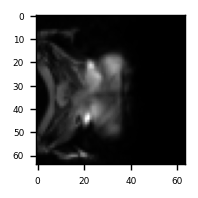

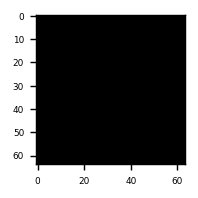

In [13]:
import matplotlib
matplotlib.rcParams.update({'font.size': 5})
for _ in range(1):
    for i, batch in enumerate(zip(dataloader, dataloader2)):
      
        '''
        CT IMAGE
        '''
        plt.figure(figsize = (1.5,1.5), dpi=128)
        plt.imshow(batch[0]["input"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        plt.tight_layout()
        plt.show()

        '''
        CT seg mask
        '''

        plt.figure(figsize = (1.5,1.5), dpi=128)
        plt.imshow(batch[0]["gt"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        plt.tight_layout()
        plt.show()


        '''
        MRI image
        '''

        # plt.figure(figsize = (1.5,1.5), dpi=128)
        # plt.imshow(batch[1]["input"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        # plt.tight_layout()
        # plt.show()

        break

In [14]:


for i,b in enumerate(zip(dataloader, dataloader2)):
    # print(b[0])
    # print('222')
    print(b[0]["input"].shape)
    break
    # assert b[0]['input'].size()[2]==256
    # assert b[0]['input'].size()[3]==256

    # print(b['input'].size())

'''
visualize images
'''
def vis(image):
    plt.imshow(image[0].detach().cpu().permute(1,2,0)[:,:,0],cmap='gray')
    plt.show()

torch.Size([1, 1, 64, 64])


In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

        

  

In [16]:
# https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/21
# https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/ops/random_ops.py#L163

def truncated_normal(t, mean=0.0, std=0.01):
    torch.nn.init.normal_(t, mean=mean, std=std)
    while True:
      cond = torch.logical_or(t < mean - 2*std, t > mean + 2*std)
      if not torch.sum(cond):
        break
      t = torch.where(cond.cuda(), torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std).cuda(), t.cuda()).cuda()
      
    # return t

def compute_conv_output(H, K, S):
  return int(((H-K+2*0)/S)+1)

def compute_padding(out, H, K, S):
  return int((S*(out-1)-H+K)/2)

def compute_padding_deconv(out, H, K, S):
  return int((-out+(H-1)*S+K)/2)

def compute_maxpool_padding(S, H, f):
  '''
  H2=(H1-f)/s+1
  '''
  return int((S*(H-1)-H+f)/2)


In [17]:

class General_Conv2D(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.01)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.01, do_relu=True, keep_rate=0.75, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0):
        super(General_Conv2D, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding

        self.dropout = nn.Dropout(p=keep_rate)
        
        if norm_type=='Batch':
          if train:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          if train:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU()
        self.lrealu=nn.LeakyReLU()
        
        self.w= nn.Parameter(torch.randn(out_features, in_features, k,k))
        truncated_normal(self.w)
        self.b=nn.Parameter(torch.randn(out_features))

    def forward(self, x):

        '''
        initialize weights
        '''
        
        if self.padding==False:
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        
        '''
        dropout
        '''
        if not self.keep_rate is None:
          x=self.dropout(x)

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        elif (self.norm_type=='Ins'):
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)
        
        

        return x

        # return x + self.block(x)


class Resnet_Block(nn.Module):
    def __init__(self, in_features, out_features , padding="REFLECT", norm_type=None, keep_rate=0.75):
        super(Resnet_Block, self).__init__()

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)

        self.block = nn.Sequential(
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, norm_type=norm_type, keep_rate=keep_rate, padding=False),
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, do_relu=False, norm_type=norm_type, keep_rate=keep_rate, padding=False)
        )

        # self.l1=nn.ReflectionPad2d(1)
        # self.l2=General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, norm_type=norm_type, keep_rate=keep_rate, padding='VALID')
        # self.l3=nn.ReflectionPad2d(1)
        # self.l4=General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, do_relu=False, norm_type=norm_type, keep_rate=keep_rate, padding='VALID')

        self.relu=nn.ReLU()

    def forward(self, x):
        # print(x.shape)
        # x=self.l1(x)
        # print(x.shape)
        # x=self.l2(x)
        # print(x.shape)
        # x=self.l3(x)
        # print(x.shape)
        # x=self.l4(x)
        # print(x.shape)

        # print(x.shape)
        out = self.block(x)
        # print(out.shape)

        return self.relu(out+x)

class Resnet_Block_ds(nn.Module):
    def __init__(self, in_features=0, out_features=0, padding="REFLECT",dim=0, norm_type=None, keep_rate=0.75):
        super(Resnet_Block_ds, self).__init__()

        self.in_features=in_features
        self.out_features=out_features

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)


        self.block = nn.Sequential(
            
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, norm_type=norm_type, keep_rate=keep_rate, padding=False),
            pad_layer,
            General_Conv2D(out_features, out_features, k=3, s=1, stddev=0.01, do_relu=False, norm_type=norm_type, keep_rate=keep_rate, padding=False)
        )

    def forward(self, x):
     
        out = self.block(x)
        '''
        pad channel dim
        '''
        pd=(self.out_features-self.in_features) // 2

        padding = torch.zeros(x.shape[0], pd, x.shape[2], x.shape[3]).cuda()
        padded_inp = torch.cat((x, padding), 1)
        padded_inp = torch.cat((padding, padded_inp), 1)


        return torch.nn.functional.relu(out+padded_inp)
  
class drn_Block(nn.Module):
    def __init__(self, in_features, keep_rate=0.75):
        super(drn_Block, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(2),
            nn.Conv2d(in_features, in_features, 3, dilation=2),
            nn.Dropout(0.75),
            nn.BatchNorm2d(in_features),
            nn.ReLU(),
            nn.ReflectionPad2d(2),
            nn.Conv2d(in_features, in_features, 3, dilation=2),
            nn.Dropout(0.75),
            nn.BatchNorm2d(in_features),
        )

    def forward(self, x):
        x = x + self.block(x)
        

        return torch.nn.functional.relu(x)


class General_Conv2D_GA(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.02)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.02, do_relu=True, keep_rate=0.75, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0):
        super(General_Conv2D_GA, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding

        self.dropout = nn.Dropout(p=keep_rate)
        
        if norm_type=='Batch':
          if train:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          if train:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU()
        self.lrealu=nn.LeakyReLU()
        
        self.w= nn.Parameter(torch.randn(out_features, in_features, k,k))
        truncated_normal(self.w)
        self.b=nn.Parameter(torch.randn(out_features))
        torch.nn.init.constant_(self.b, 0)

    def forward(self, x):

        '''
        initialize weights
        '''
        
        # print('GA')
        # print(x.shape)

        if self.padding==False:
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        
        '''
        dropout
        '''
        if not self.keep_rate is None:
          x=self.dropout(x)

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        elif self.norm_type=='Ins':# Instance norm
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)
        
       

        return x

        # return x + self.block(x)


class Resnet_Block_ins(nn.Module):
    def __init__(self, in_features=0, out_features=0, padding="REFLECT",dim=0, norm_type=None, keep_rate=0.75):
        super(Resnet_Block_ins, self).__init__()

        self.in_features=in_features
        self.out_features=out_features

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)


        self.block = nn.Sequential(
            
            pad_layer,
            General_Conv2D_GA(in_features, out_features, k=3, s=1, stddev=0.02, norm_type='Ins', keep_rate=keep_rate, padding=False, do_relu=True),
            pad_layer,
            General_Conv2D_GA(out_features, out_features, k=3, s=1, stddev=0.02, norm_type='Ins', keep_rate=keep_rate, padding=False, do_relu=False)
        )

    def forward(self, x):
     
        out = self.block(x)
        
        return torch.nn.functional.relu(out+x)

class General_Deconv2D(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.02)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.02, do_relu=True, keep_rate=0.75, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0, out_shape=0):
        super(General_Deconv2D, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding
        self.out_shape=out_shape
        
        if norm_type=='Batch':
          if train:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          if train:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU()
        self.lrealu=nn.LeakyReLU()
        
        self.w= nn.Parameter(torch.randn(in_features, out_features, k,k))
        truncated_normal(self.w)
        self.b=nn.Parameter(torch.randn(out_features))
        torch.nn.init.constant_(self.b, 0)

    def forward(self, x):

        '''
        initialize weights
        '''

        # print('deconv')
        # print(x.shape)

        if self.padding==False:
          x = torch.nn.functional.conv_transpose2d(x, self.w, bias=self.b, stride=self.s, padding=0)
          # x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          x = torch.nn.functional.conv_transpose2d(x, self.w, bias=self.b, stride=self.s, padding=compute_padding_deconv(self.out_shape, x.shape[-1], self.k, self.s))
          # x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        else:# Instance norm
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)


        'explicit resize'
        # x=torch.reshape(x, (x.shape[0], x.shape[1], x.shape[2]-1, x.shape[3]-1))
        '''
        Here?
        '''
        x=x[:,:,:self.out_shape,:self.out_shape]
        

        return x

        # return x + self.block(x)

In [18]:
class GeneratorResNet(nn.Module):
    def __init__(self, skip=True):
        super(GeneratorResNet, self).__init__()

        self.skip=skip
        # self.input_img=input_img
        
        self.block = nn.Sequential(
            nn.ZeroPad2d(3),
            General_Conv2D_GA(in_features=1, out_features=32, k=7, s=1, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=False),
            General_Conv2D_GA(in_features=32, out_features=32*2, k=3, s=2, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=True),
            General_Conv2D_GA(in_features=32*2, out_features=32*4, k=3, s=2, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=True),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            General_Deconv2D(in_features=32*4, out_features=32*2, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=32, padding=True),
            General_Deconv2D(in_features=32*2, out_features=32, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=64, padding=True),
            General_Conv2D_GA(in_features=32, out_features=1, k=7, s=1, stddev=0.02, do_relu=False, train=True, padding=True),
            )
        

    def forward(self, x):
      out=self.block(x)
      if self.skip==True:
        
        return torch.nn.functional.tanh(x+out)
      else:
        return torch.nn.functional.tanh(out)




In [19]:
'''
input shape: B,C,H,W
'''
class EncoderNet(nn.Module):
    def __init__(self, train, input_shape):
        super(EncoderNet, self).__init__()
        self.train=train
        self.input_shape=input_shape

  

        self.out_c1 = General_Conv2D(in_features=1, out_features=16, padding=True, train=self.train, input_dim=self.input_shape[-1], norm_type='Batch')
        self.out_res1 = Resnet_Block(in_features=16,out_features=16,norm_type='Batch')
        self.out1 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=input_shape[-1], f=1))
        
        self.out_res2 = Resnet_Block_ds(in_features=16, out_features=16*2, norm_type='Batch', padding='CONSTANT')
        # self.out2 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=input_shape[-1], f=1))

        self.out_res3 = Resnet_Block_ds(in_features=16*2, out_features=16*4, norm_type='Batch', padding='CONSTANT')
        self.out_res4 = Resnet_Block(in_features=16*4,out_features=16*4,norm_type='Batch', padding='CONSTANT')
        # self.out3 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=input_shape[-1], f=1))

        self.out_res5 = Resnet_Block_ds(in_features=16*4,out_features=16*8,norm_type='Batch', padding='CONSTANT')
        self.out_res6 = Resnet_Block(in_features=16*8,out_features=16*8,norm_type='Batch', padding='CONSTANT')

        self.out_res7 = Resnet_Block_ds(in_features=16*8,out_features=16*16,norm_type='Batch', padding='CONSTANT')
        self.out_res8 = Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT')

        self.out_res9 = Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT')
        self.out_res10= Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT')

        self.out_res11= Resnet_Block_ds(in_features=16*16,out_features=16*32,norm_type='Batch', padding='CONSTANT')
        self.out_res12= Resnet_Block(in_features=16*32,out_features=16*32,norm_type='Batch', padding='CONSTANT')

        self.out_drn1 = drn_Block(in_features=16*32)
        self.out_drn2 = drn_Block(in_features=16*32)
        
        self.out_c2 = General_Conv2D(in_features=16*32, out_features=16*32, k=3, padding=True, train=self.train, input_dim=0, norm_type='Batch')
        self.out_c3 = General_Conv2D(in_features=16*32, out_features=16*32, k=3, padding=True, train=self.train, input_dim=0, norm_type='Batch')


    def forward(self, x):
        # x = General_Conv2D(in_features=3, out_features=16, padding='SAME', train=self.train, input_dim=self.input_dim, norm_type='Batch')(x)
        # x = Resnet_Block(in_features=x.shape[1],out_features=out,norm_type='BATCH')(x)
        '''
        separate kernel size implementation from tf not available in pytorch
        TODO
        '''
  #       def compute_maxpool_padding(S, H, f):
  # return (S*(H-1)-H+f)/2
        
        # x = nn.MaxPool2D(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))

        # x = Resnet_Block_ds(in_features=x.shape[1], out_features=16*2, dim=16, norm_type='Batch', padding='CONSTANT')(X)
        x=self.out_c1(x)
        x=self.out_res1(x)
        x=self.out1(x)
        x=self.out_res2(x)
        self.out2 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        x=self.out2(x)
        x=self.out_res3(x)
        x=self.out_res4(x)
        self.out3 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        x=self.out3(x)
        x=self.out_res5(x)
        x=self.out_res6(x)
        x=self.out_res7(x)
        x=self.out_res8(x)
        x=self.out_res9(x)
        x=self.out_res10(x)
       
        x=self.out_res11(x)
        x=self.out_res12(x)
        y=x
        x=self.out_drn1(x)
        x=self.out_drn2(x)
        '''
        '''
        x=self.out_c2(x)
        x=self.out_c3(x)

        return x, y

In [20]:
class DecoderNet(nn.Module):
    def __init__(self, input_shape, skip=False, train=False):
        super(DecoderNet, self).__init__()
        
        self.skip=skip
        self.train=train
        self.input_shape=input_shape
        
        self.block = nn.Sequential(
          General_Conv2D(in_features=self.input_shape[1], k=3, s=1, out_features=32*4, padding=True, train=self.train, input_dim=self.input_shape[-1], norm_type='Ins'),
          Resnet_Block(in_features=32*4,out_features=32*4, padding='CONSTANT', norm_type='Ins'),
          Resnet_Block(in_features=32*4,out_features=32*4,padding='CONSTANT',norm_type='Ins'),
          Resnet_Block(in_features=32*4,out_features=32*4,padding='CONSTANT',norm_type='Ins'),
          Resnet_Block(in_features=32*4,out_features=32*4,padding='CONSTANT',norm_type='Ins'),
          General_Deconv2D(in_features=32*4, out_features=32*2, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=16, padding=True),
          General_Deconv2D(in_features=32*2, out_features=32*2, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=32, padding=True),
          General_Deconv2D(in_features=32*2, out_features=32, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=64, padding=True),
          General_Conv2D(in_features=32, out_features=1, k=7, s=1, norm_type=None, do_relu=False, stddev=0.02, padding=True, train=self.train, input_dim=self.input_shape[-1])
        )

    def forward(self, x, input_img):
      out=self.block(x)

      if self.skip==True:
        return torch.nn.functional.tanh(input_img+out)
      else:
        return torch.nn.functional.tanh(out)

In [21]:
class Discriminator(nn.Module):
    def __init__(self, input_shape, skip=False, train=False):
        super(Discriminator, self).__init__()
        
        self.skip=skip
        self.train=train
        self.input_shape=input_shape

        self.block = nn.Sequential(
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=self.input_shape[1], out_features=64, k=4, s=2, stddev=0.02, padding=False, train=self.train, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type=None),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64, out_features=64*2, k=4, s=2, stddev=0.02, padding=False, train=self.train, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*2, out_features=64*4, k=4, s=2, stddev=0.02, padding=False, train=self.train, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*4, out_features=64*8, k=4, s=1, stddev=0.02, padding=False, train=self.train, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*8, out_features=1, k=4, s=1, stddev=0.02, padding=False, train=self.train, input_dim=self.input_shape[-1], norm_type=None, do_relu=False),
        )

    def forward(self, x):
      return self.block(x)

In [22]:
class Discriminator_aux(nn.Module):
    def __init__(self, input_shape, skip=False, train=False):
        super(Discriminator_aux, self).__init__()
        
        self.skip=skip
        self.train=train
        self.input_shape=input_shape

        self.block = nn.Sequential(
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=self.input_shape[1], out_features=64, k=4, s=2, stddev=0.02, padding=False, train=self.train, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type=None),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64, out_features=64*2, k=4, s=2, stddev=0.02, padding=False, train=self.train, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*2, out_features=64*4, k=4, s=2, stddev=0.02, padding=False, train=self.train, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*4, out_features=64*8, k=4, s=1, stddev=0.02, padding=False, train=self.train, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*8, out_features=1, k=4, s=1, stddev=0.02, padding=False, train=self.train, input_dim=self.input_shape[-1], norm_type=None, do_relu=False),
        )

    def forward(self, x):
      out=self.block(x)
      # return out, out
      return torch.unsqueeze(out[...,0], dim=3), torch.unsqueeze(out[...,1], dim=3) 

In [23]:
'''
Params
'''
LAMBDA_A=10
LAMBDA_B=10

In [24]:
'''
Losses
'''

'''
Copute lsgan loss for generator
'''
def lsgan_loss_generator(prob_fake_is_real):
    return (torch.mean((prob_fake_is_real - 1)**2))

'''
Compute lsgan loss (which needs to be minimized) (lsgan to help with vanishing/exploding gradients)?
'''
def lsgan_loss_discriminator(prob_real_is_real, prob_fake_is_real):
    return (torch.mean((prob_real_is_real - 1)**2) + torch.mean((prob_fake_is_real - 0)**2))*0.5

    # return (torch.mean(torch.nn.MSELoss(prob_real_is_real, 1)) + torch.mean(torch.nn.MSELoss(prob_fake_is_real, 0)))*0.5


'''
Compute cycle loss
'''
def cycle_consistency_loss(real_images, generated_images):
    return (torch.mean(torch.abs(real_images - generated_images)))


In [25]:

'''
plotting library
'''
# vis=visdom.Visdom()

'\nplotting library\n'

In [26]:
import argparse
import os
import numpy as np
import math
import itertools
import datetime
import time
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import sys
import random


cuda = torch.cuda.is_available()


# Initialize generator and discriminator

# G_AB = GeneratorResNet((1, 128, 128), 9)
# G_BA = GeneratorResNet((1, 128, 128), 9)
# D_A = Discriminator((1, 128, 128))
# D_B = Discriminator((1, 128, 128))


'''
Encoder
'''
Encoder = EncoderNet(train=True, input_shape=(2,1,128,128))
'''
Decoder
'''
Decoder = DecoderNet(train=True, input_shape=(1,512,128,128))

'''
Discriminator
'''
discriminator = Discriminator((1,1,128,128))
discriminator_aux = Discriminator_aux((1,1,128,128))

'''
Generators
'''
G_A=GeneratorResNet(skip=True)
# G_B=GeneratorResNet(skip=True)

if cuda:
    Encoder = Encoder.cuda()
    Decoder = Decoder.cuda()
    discriminator = discriminator.cuda()
    discriminator_aux=discriminator_aux.cuda()
    G_A=G_A.cuda()
    # G_B=G_B.cuda()



#Optimizer for Generators (G_A and E/D)
optimizer_G = torch.optim.Adam(lr=0.0002, params=itertools.chain(G_A.parameters(), Encoder.parameters(), Decoder.parameters()))
# D_B
optimizer_D_B=torch.optim.Adam(lr=0.0002, params=discriminator.parameters())
#
optimizer_D_A=torch.optim.Adam(lr=0.002, params=discriminator_aux.parameters())


# optimizer = torch.optim.Adam(lr=0.0002, params=list(Encoder.parameters())+list(Decoder.parameters())+list(discriminator.parameters())+list(discriminator_aux.parameters())+list(G_A.parameters()))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

opt={"lr":0.0002,"b1":0.5, "b2":0.999, "n_epochs":50, "decay_epoch":5, "lambda_cyc":10.0, "lambda_id":5.0}


'''
Training loop starts
'''
for epoch in range(opt["n_epochs"]):
    for i, batch in enumerate(zip(dataloader, dataloader2)):
       
        if (i==1):
          i=0
          break
       
        # plt.imshow(batch[0]["input"].squeeze())
        # plt.show()
        # Set model input
        with torch.autograd.set_detect_anomaly(True):

          real_A = Variable(batch[0]["input"].type(Tensor)) # mri
          real_B = Variable(batch[1]["input"].type(Tensor)) # ct

          '''
          zero gradients
          '''
          
        
          '''
          forward pass for images_A
          '''
          ################ Computing GAN Losses
          '''
          Optimizing G_A network
          (real_A -> fake_B)
          '''

          optimizer_G.zero_grad()

          fake_imgs_b = G_A(real_A)

          '''
          D_B Discriminator
          '''
          prob_fake_b_is_real = discriminator(fake_imgs_b)
          lsgan_loss_b = lsgan_loss_generator(prob_fake_b_is_real)

          '''
          Optimizing the G_B network E/D 
          (real_B -> fake_A)
          '''

          latent_real_b, latent_real_b_II = Encoder(real_B)
          fake_imgs_a = Decoder(latent_real_b, real_B)

          '''
          D_A discriminator
          '''
          prob_fake_a_is_real, prob_fake_a_aux_is_real = discriminator_aux(fake_imgs_a)
          lsgan_loss_a = lsgan_loss_generator(prob_fake_a_is_real)

          '''
          Not adding lsgan_loss_a and lsgan_loss_b ?
          '''

          ##################### GAN Cycle loss

          latent_fake_b, latent_fake_b_II = Encoder(fake_imgs_b)
          cycle_imgs_a = Decoder(latent_fake_b, fake_imgs_b)
          
          cycle_consistency_loss_a = LAMBDA_A * cycle_consistency_loss(real_images=real_A, generated_images=cycle_imgs_a)
          
          cycle_imgs_b = G_A(fake_imgs_a)
          cycle_consistency_loss_b = LAMBDA_B * cycle_consistency_loss(real_images=real_B, generated_images=cycle_imgs_b)

          
          ####################### Total Generator losses (not adding g_loss_a and g_loss_b ?)
          '''
          final G_A loss 
          '''
          g_loss_a = cycle_consistency_loss_a + cycle_consistency_loss_b + lsgan_loss_b
          '''
          final E/D loss
          '''
          g_loss_b = cycle_consistency_loss_b + cycle_consistency_loss_a + lsgan_loss_a

          '''
          backward
          '''
          g_loss_a.backward(retain_graph=True)
          g_loss_b.backward(retain_graph=True)
          optimizer_G.step()

          ############### Computing Discriminator losses
          ############### Computing D_A loss
          optimizer_D_B.zero_grad()
          '''
          Optimizing the D_B network
          '''
          # TODO
          # fake_pool_b = self.fake_image_pool(
              # self.num_fake_inputs, fake_B_temp, self.fake_images_B)
          '''
          FOR NOW JUST SEETING fake_pool_a and fake_pool_b to fake_a and fake_b
          '''
          
          fake_pool_b=fake_imgs_b
          fake_pool_b=fake_pool_b.detach()
          prob_real_b_is_real = discriminator(real_B)
          prob_fake_pool_b_is_real = discriminator(fake_pool_b)

          d_loss_b = lsgan_loss_discriminator(prob_real_b_is_real, prob_fake_pool_b_is_real)

          '''
          backward
          '''
          d_loss_b.backward()
          optimizer_D_B.step()

          ############### Computing D_B loss
          '''
          Optimizing the D_A network
          '''

          optimizer_D_A.zero_grad()
          '''
          FOR NOW JUST setting
          '''
          fake_pool_a = fake_imgs_a
          fake_pool_a=fake_pool_a.detach()
          prob_real_a_is_real, prob_real_a_aux = discriminator_aux(real_A)
          prob_fake_pool_a_is_real, prob_fake_pool_a_aux_is_real = discriminator_aux(fake_pool_a)

          d_loss_a = lsgan_loss_discriminator(
              prob_real_a_is_real,
              prob_fake_pool_a_is_real,
          )

          '''
          ???? 
          '''
          cycle_imgs_a=cycle_imgs_a.detach()
          prob_cycle_a_is_real, prob_cycle_a_aux_is_real = discriminator_aux(cycle_imgs_a)
          # prob_cycle_a_aux_is_real= prob_cycle_a_aux_is_real.detach()

          d_loss_a_aux = lsgan_loss_discriminator(
              prob_cycle_a_aux_is_real,
              prob_fake_pool_a_aux_is_real,
          )

          d_loss_a = d_loss_a + d_loss_a_aux

          '''
          backward
          '''
          d_loss_a.backward()
          optimizer_D_A.step()

          # loss_window = vis.line(
          #     Y=torch.zeros((1)).cpu(),
          #     X=torch.zeros((1)).cpu(),
          #     opts=dict(xlabel='epoch',ylabel='Loss',title='training loss',legend=['Loss'])
          #     )
          
          # vis.line(X=torch.ones((1,1)).cpu()*epoch, Y=g_loss_a,win=loss_window, update='append')

          sys.stdout.write(
              "\r[Epoch %d/%d] [Batch %d/%d] [D_A loss: %f] [D_B loss: %f] [G_A loss: %f] [G_B loss: %f]"
              % (
                  epoch,
                  opt["n_epochs"],
                  i,
                  len(dataloader),
                  d_loss_a.item(),
                  d_loss_b.item(),
                  g_loss_a.item(),
                  g_loss_b.item(),
              )
          )


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[Epoch 0/50] [Batch 0/160] [D_A loss: 28.502110] [D_B loss: 1.953417] [G_A loss: 5912.486328] [G_B loss: 5942.824707]

RuntimeError: ignored

In [ ]:
plt.imshow(cycle_imgs_a.detach().cpu().squeeze(),cmap='gray')
plt.show()
plt.imshow(real_A.detach().cpu().squeeze(),cmap='gray')
plt.show()
# import numpy as np
# import tensorflow as tf

# x = tf.Variable(np.empty((2, 16, 120,120), dtype=np.float32))
# y = tf.Variable(np.empty((2, 16, 120,120), dtype=np.float32))
# print((x+y).shape)

# a = torch.empty((2,16,120,120))
# b = torch.empty((2,16,120,120))
# print((a+b).shape)

In [ ]:
# # vis(G_AB(real_B))
# # vis(G_AB(real_A))
# # vis(real_B)

# # vis(real_B)
# # vis(G_BA(real_B))


# for _ in range(1):
#     for i, batch in enumerate(zip(dataloader, dataloader2)):
#         vis(G_AB(real_B))
#         vis(real_B)

#         vis(G_BA(real_A))
#         vis(real_A)
        
#       # GAN loss
#         # fake_B = G_AB(real_A)

#         # print(fake_B[0].shape)
        
#         # plt.imshow(fake_B[0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
#         # plt.show()

#         break

In [ ]:
# # test forward pass
# G_AB = GeneratorResNet((1, 256, 256), 9)
# G_BA = GeneratorResNet((1, 256, 256), 9)
# G_AB.train()
# G_BA.train()
# optimizer_G = torch.optim.Adam(
#     itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999)
# )
# # for epoch in range(1):
# for i, batch in enumerate(dataloader):
#   G_AB(batch["input"])
    
'''class mrctDataset(Dataset):
    """MR CT dataset."""

    def __init__(self, root_dir, transform=None):
        
        self.files_A = glob.glob(os.path.join(root_dir, "ct_train")+"/*image.nii")
        self.files_B = glob.glob(os.path.join(root_dir, "mri_train")+"/*image.nii")

    def __len__(self):
        return (max(len(self.files_A), len(self.files_B)))

    def __getitem__(self, idx):
      nii_image_A = nib.load(self.files_A[idx])
      nii_image_B = nib.load(self.files_B[idx])

      return {'A':nii_image_A, 'B':nii_image_B}'''

 

In [ ]:
'''mrct_dataset = mrctDataset(root_dir='/gdrive/My Drive/data/')
print(mrct_dataset[0]['A'])'''

In [ ]:
# # for i,b in enumerate(dataloader):
# #     print(b['input'].size())
# #     break

# for i,b in enumerate(zip(dataloader, dataloader2)):
#     # print(b[0])
#     # print('222')
#     # print(b[0]["input"].shape)
#     vis(b[0]["input"])
#     vis(b[1]["input"])
#     break
#     # assert b[0]['input'].size()[2]==256
#     # assert b[0]['input'].size()[3]==256

#     # print(b['input'].size())